In [1]:
import os.path as osp
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.backends import cudnn
import random

from configs import *
from face_dataset import *


In [2]:
configs = Configs()
ROOT_DIR = configs.root_dir
image_dir = os.path.join(ROOT_DIR, 'CelebA-HQ-img')

In [3]:
def list_preprocess(image_dir, mask_dir):
    train_dataset = []
    test_dataset = []
    for i in range(len([name for name in os.listdir(image_dir) if osp.isfile(osp.join(image_dir, name))])):
        img_path = osp.join(image_dir, str(i)+'.jpg')
        label_path = osp.join(mask_dir, str(i)+'.png')
        train_dataset.append([img_path, label_path])
    return train_dataset


In [4]:
train_indices = set()
indices_file_pth = os.path.join(ROOT_DIR, 'train.txt')
with open(indices_file_pth, 'r') as file:
    train_indices = set(map(int, file.read().splitlines()))
    
sample_indices = list(range(len(os.listdir(image_dir))))
test_indices = [idx for idx in sample_indices if idx not in train_indices]

# Split indices into training and validation sets
train_indices = list(train_indices)
valid_indices = train_indices
if configs.debug:
    train_indices = train_indices[:100]         
    train_indices, valid_indices = train_test_split(train_indices, test_size=VAL_SIZE, random_state=SEED)
print(len(train_indices))
if configs.debug:
    print(len(valid_indices)) 
print(len(test_indices))

24000
6000


In [5]:

root_dir = configs.root_dir

image_dir = os.path.join(root_dir, 'CelebA-HQ-img')  # Path to image folder
mask_dir = os.path.join(root_dir, 'mask')    # Path to mask folder
train_dataset = list_preprocess(image_dir, mask_dir)
print(len(train_dataset))
# sample_indices = sample_indices

30000


In [6]:
train_dataset = list_preprocess(image_dir, mask_dir)
print(train_dataset[0])


['/home/hsu/HD/CV/CelebAMask-HQ/CelebA-HQ-img/0.jpg', '/home/hsu/HD/CV/CelebAMask-HQ/mask/0.png']


In [7]:
idx_1 = random.randint(0, len(train_indices))
idx_2 = random.randint(1, len(train_indices))
print(idx_1)
print(idx_2)
idx_1 = train_indices[idx_1]
idx_2 = train_indices[idx_2]

img1_pt, img1_mask_pt = train_dataset[idx_1]
img2_pt, img2_mask_pt = train_dataset[idx_2]

# img1 = cv2.imread(img1_pt)
# img1_mask = cv2.imread(img1_mask_pt)
# img2 = cv2.imread(img2_pt)
# img2_mask = cv2.imread(img2_mask_pt)

img1 = Image.open(img1_pt).convert('RGB')
img1 = img1.resize((512, 512), Image.BILINEAR)
img1_mask = Image.open(img1_mask_pt).convert('L')

img2 = Image.open(img2_pt).convert('RGB')
img2 = img2.resize((512, 512), Image.BILINEAR)
img2_mask = Image.open(img2_mask_pt).convert('L')




12897
2501


In [8]:
print(img1_mask.size)
test = np.array(img1_mask)
np.unique(test)

(512, 512)


array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 16, 17],
      dtype=uint8)

In [9]:
img1_one_hot_mask = one_hot_encode(np.array(img1_mask), 19)    # (h,w) -> (19, h, w)
img2_one_hot_mask = one_hot_encode(np.array(img2_mask), 19)    # (h,w) -> (19, h, w)
print(np.unique(img1_one_hot_mask[0]))
print(np.unique(img2_one_hot_mask[0]))

img1_bg_mask = img1_one_hot_mask[0]
img2_bg_mask = img2_one_hot_mask[0]



[0 1]
[0 1]


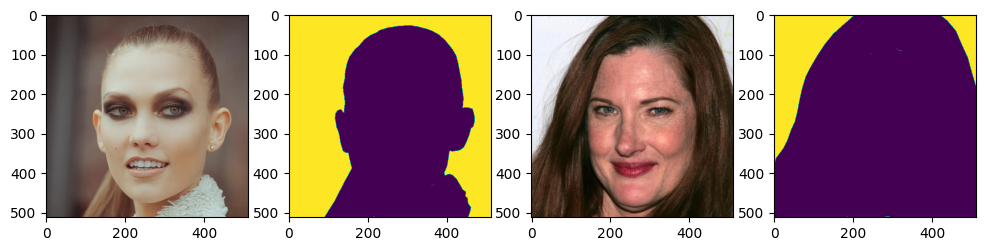

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(1, 4, 1)
plt.imshow(img1)
plt.subplot(1, 4, 2)
plt.imshow(img1_bg_mask)
plt.subplot(1, 4, 3)
plt.imshow(img2)
plt.subplot(1, 4, 4)
plt.imshow(img2_bg_mask)
plt.show()

In [11]:
# def get_mask_from_padded_mask(padded_mask, size=512):
#     start = (padded_mask.shape[0]-size) // 2
#     return padded_mask[start : start+size, start : start+size]

In [12]:
# bigger mask with all 1s outside the mask
# padded_img2_bg_mask = np.pad(img2_bg_mask, ((512, 512), (512, 512)), mode='constant', constant_values=1)
# img2_center_mask = get_mask_from_padded_mask(padded_img2_bg_mask)

# plt.subplot(1, 3, 1)
# plt.imshow(img2_bg_mask)
# plt.subplot(1, 3, 2)
# plt.imshow(padded_img2_bg_mask)
# plt.subplot(1, 3, 3)
# plt.imshow(img2_center_mask)
# plt.show()
# img2_bg_mask
# img2_center_mask.shape

In [13]:
# Specify the number of pixels to shift
tx = 300  # Shift along the x-axis (horizontal)
ty = 50  # Shift along the y-axis (vertical)
# Create the translation matrix
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])

# Apply the translation using cv2.warpAffine
img2 = np.array(img2)
img1 = np.array(img1)
translated_img2 = cv2.warpAffine(img2, translation_matrix, (img2.shape[1], img2.shape[0]))
translated_img2_bg_mask = cv2.warpAffine(img2_bg_mask, translation_matrix, (img2.shape[1], img2.shape[0]))
# translated_img2_center_mask = get_mask_from_padded_mask(translated_padded_img2_bg_mask)

# fill the edge of the translated mask with 1s
if tx < 0:
    x_start = img2.shape[1] - abs(tx)
    x_end = img2.shape[1]
else:
    x_start = 0
    x_end = tx

if ty < 0:
    y_start = img2.shape[0] - abs(ty)
    y_end = img2.shape[0]
else:
    y_start = 0
    y_end = ty

print(x_start, x_end)
print(y_start, y_end)
translated_img2_bg_mask[:, x_start:x_end] = 1
translated_img2_bg_mask[y_start:y_end, :] = 1

0 300
0 50


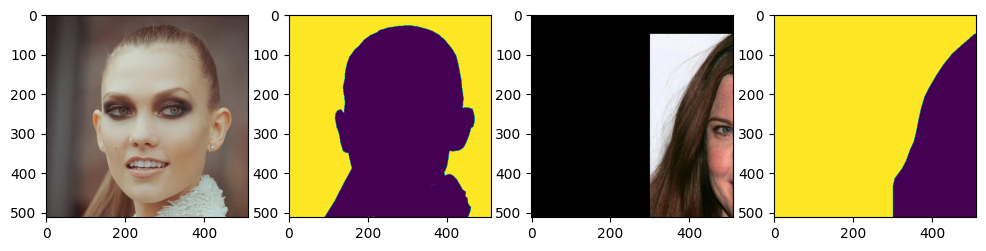

In [14]:
plt.figure(figsize=(12,12))
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1, 4, 1)
plt.imshow(img1)
plt.subplot(1, 4, 2)
plt.imshow(img1_bg_mask)
plt.subplot(1, 4, 3)
plt.imshow(translated_img2)
# plt.imshow(segmented_image)
plt.subplot(1, 4, 4)
plt.imshow(translated_img2_bg_mask)
# plt.subplot(1, 5, 5)
# plt.imshow(translated_img2_center_mask)
plt.show()

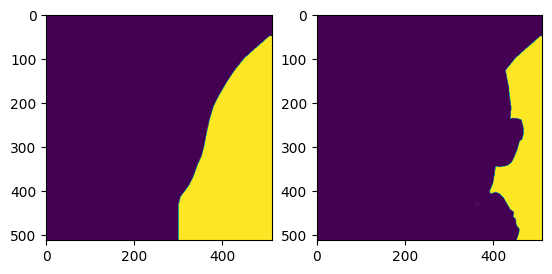

In [15]:
inverted_trans_img2_bg_mask = cv2.bitwise_not(translated_img2_bg_mask)
intersection_mask = cv2.bitwise_and(img1_bg_mask, inverted_trans_img2_bg_mask)
plt.subplot(1,2,1)
plt.imshow(inverted_trans_img2_bg_mask)
plt.subplot(1,2,2)
plt.imshow(intersection_mask)
plt.show()


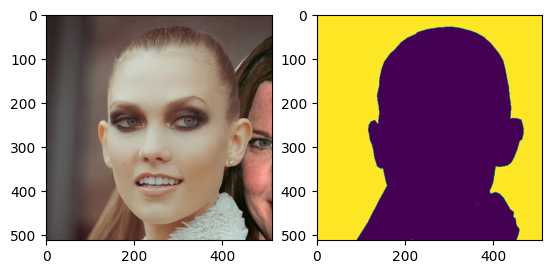

In [16]:
indices = np.where(intersection_mask == 1)
synth_img = img1.copy()
synth_img[indices] = translated_img2[indices]
plt.subplot(1,2,1)
plt.imshow(synth_img)
plt.subplot(1,2,2)
plt.imshow(img1_bg_mask)
plt.show()

In [17]:
def synthesize_imgs(img1, img1_mask, img2, img2_mask, least_shift=50, max_shift=350, ratio=0.15):
    # get the bg mask
    img1_one_hot_mask = one_hot_encode(np.array(img1_mask), 19)    # (h,w) -> (19, h, w)
    img2_one_hot_mask = one_hot_encode(np.array(img2_mask), 19)    # (h,w) -> (19, h, w)
    img1_bg_mask = img1_one_hot_mask[0]
    img2_bg_mask = img2_one_hot_mask[0] 
    img2 = np.array(img2)
    img1 = np.array(img1)
    cnt = 0
    while True:
        # Specify the number of pixels to shift
        tx = np.random.randint(least_shift, max_shift+1)  # Shift along the x-axis (horizontal)
        ty = np.random.randint(least_shift, max_shift+1)  # Shift along the y-axis (vertical)
        if random.choice([True, False]):
            tx = -tx
        if random.choice([True, False]):
            ty = -ty

        # Create the translation matrix
        translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        # Apply the translation using cv2.warpAffine
        translated_img2 = cv2.warpAffine(img2, translation_matrix, (img2.shape[1], img2.shape[0]))
        translated_img2_bg_mask = cv2.warpAffine(img2_bg_mask, translation_matrix, (img2.shape[1], img2.shape[0]))

        # fill the edge of the translated mask with 1s
        if tx < 0:
            x_start = img2.shape[1] - abs(tx)
            x_end = img2.shape[1]
        else:
            x_start = 0
            x_end = ty

        if ty < 0:
            y_start = img2.shape[0] - abs(ty)
            y_end = img2.shape[0]
        else:
            y_start = 0
            y_end = ty

        translated_img2_bg_mask[:, x_start:x_end] = 1
        translated_img2_bg_mask[y_start:y_end, :] = 1
        
        inverted_trans_img2_bg_mask = cv2.bitwise_not(translated_img2_bg_mask)
        intersection_mask = cv2.bitwise_and(img1_bg_mask, inverted_trans_img2_bg_mask)
        synth_area = np.sum(intersection_mask)
        total_area = img1.shape[0] * img1.shape[1]
        if synth_area > total_area*ratio:
            break
        else:
            cnt += 1
        if cnt > 100:
            return None, None, None
    
    indices = np.where(intersection_mask == 1)
    synth_img = img1.copy()
    synth_img[indices] = translated_img2[indices]
    synth_mask = img1_mask
    synth_bg_mask = img1_bg_mask
    # print(tx, ty)
    return synth_img, synth_mask, synth_bg_mask


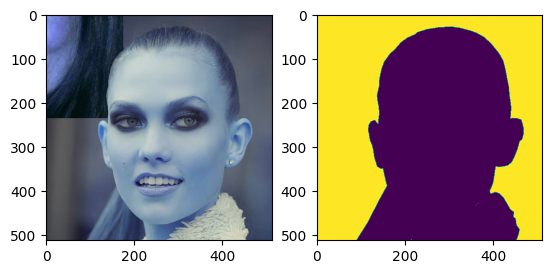

In [18]:
synth_img, synth_mask, synth_bg_mask = synthesize_imgs(img1, img1_mask, img2, img2_mask, least_shift=50, max_shift=350, ratio=0.1)
synth_img = cv2.cvtColor(synth_img, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,1)
plt.imshow(synth_img)
plt.subplot(1,2,2)
plt.imshow(synth_bg_mask)
plt.show()

In [19]:
synth_img = cv2.cvtColor(synth_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("/home/hsu/HD/CV/face_parsing_mod/test.jpg", synth_img)
synth_mask.save("/home/hsu/HD/CV/face_parsing_mod/test_mask.png")
mask = Image.open("/home/hsu/HD/CV/face_parsing_mod/test_mask.png").convert("L")
print(np.unique(np.array(mask)))

FileNotFoundError: [Errno 2] No such file or directory: '/home/hsu/HD/CV/face_parsing_mod/test_mask.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_10011.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/masks/synth_10011.png'], ['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_10013.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/masks/synth_10013.png'], ['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_10014.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/masks/synth_10014.png'], ['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_1004.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/masks/synth_1004.png'], ['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_10049.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/masks/synth_10049.png'], ['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_10053.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/masks/synth_10053.png'], ['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_10059.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/masks/synth_10059.png'], ['/home/hsu/HD/CV/Synth-CelebAMask-HQ/synth-img/synth_10062.jpg', '/home/hsu/HD/CV/Synth-CelebAMask-HQ/ma

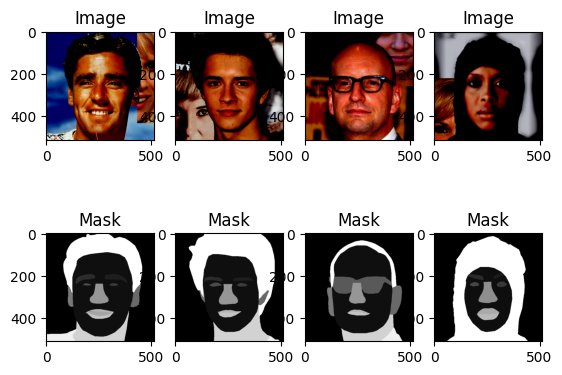

In [23]:
 ROOT_DIR = "/home/hsu/HD/CV/Synth-CelebAMask-HQ/"
 synth_trainset = Synth_CelebAMask_HQ_Dataset(root_dir=ROOT_DIR, 
                                mode='train', 
                                augmentation=None,
                                tr_transform=None)
 
from torch.utils.data import DataLoader

# Define a DataLoader to get batches of samples
dataloader = DataLoader(synth_trainset, batch_size=4, shuffle=True)

# Get a batch of samples
for images, masks in dataloader:
    # Visualize each sample in the batch
    print(f'b_img_size: {images.shape}')
    print(f'b_mask_size: {masks.shape}')
    for i in range(images.shape[0]):
        image = images[i].permute(1, 2, 0).numpy()  # Convert PyTorch tensor to NumPy array and rearrange dimensions
        mask = masks[i].numpy()
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Plot the image and mask side by side
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(2, 4, i + 5)
        plt.imshow(mask, cmap='gray')  # Assuming masks are grayscale
        # plt.imshow(mask)  # Assuming masks are grayscale
        plt.title('Mask')
    plt.show()
    break  # Only visualize the first batch for simplicity